<a href="https://colab.research.google.com/github/ss20648/CE888/blob/main/Lab%204/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# df files

In [6]:
df=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)

In [7]:
test_df=pd.DataFrame(df)
test_df=pd.concat([test_df.loc[:, 0], test_df.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
test_df.drop(columns=[0], inplace=True)

In [8]:
df=pd.concat([df.loc[:, 0], df.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
df.drop(columns=[0], inplace=True)

In [10]:
val_df=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_df.drop(columns=[0], inplace=True)

In [12]:
print(' highest rating : ', test_df.max(axis=0).idxmax())
print(' lowest rating : ', test_df.min(axis=0).idxmin())

 highest rating :  45
 lowest rating :  1


# Validation Data

In [20]:
arr = val_df.values
rated = np.where(arr!=99)

In [21]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original df array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_df = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_df[rated[0][idx], rated[1][idx]] = 99
  return new_df, (rated[0][idx], rated[1][idx])

In [22]:
new_arr, idx = replace(arr, 0.1)

In [23]:
val_data=pd.DataFrame(new_arr)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))
val_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,NaN,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,NaN,8.45,-7.18,-7.52,-7.43,-9.81,NaN,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,NaN,NaN,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,NaN,NaN,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,NaN,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,NaN,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,NaN
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,NaN,NaN,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,NaN,8.93,NaN,6.17,7.28,NaN,NaN,8.98,NaN,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,NaN,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,NaN,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,NaN,1.36,NaN,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,NaN,8.30,-1.26,7.77,1.89,-1.17,5.68,NaN,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,NaN,4.56,7.14,4.22,NaN,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,NaN


# Training

In [24]:
n_latent_factors = 2

user_ratings = df.values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [26]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 2) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [27]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/10:	MSE=26.126656
Iteration 2/10:	MSE=24.911142
Iteration 4/10:	MSE=24.443739
Iteration 6/10:	MSE=23.971121
Iteration 8/10:	MSE=23.494954


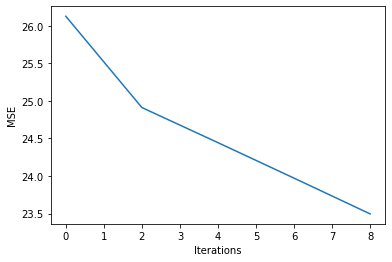

In [28]:
plt.figure()
plt.plot(np.arange(0, num_iter, 2), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

# Predict

In [31]:
pred = latent_user_preferences.dot(latent_item_features.T)
pred

array([[1.2811875 , 0.80899608, 0.84337291, ..., 1.42869325, 0.62627498,
        1.99215604],
       [0.46071185, 0.28703696, 0.30403386, ..., 0.49912634, 0.22642568,
        0.72004255],
       [1.6960652 , 1.08153457, 1.11440689, ..., 1.93121726, 0.82575442,
        2.62726107],
       ...,
       [0.93733897, 0.62180115, 0.61116583, ..., 1.1581966 , 0.448784  ,
        1.42917501],
       [1.00624458, 0.64650398, 0.66020767, ..., 1.16405709, 0.48838029,
        1.55411693],
       [1.6202829 , 1.04089125, 1.06310962, ..., 1.87391626, 0.78644353,
        2.50260269]])

# Predicting - Validation set

In [32]:
val_df=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_df.drop(columns=[0], inplace=True)
val_df=pd.DataFrame(val_df.loc[:, 0:].replace(99.00, np.NaN))

v_df=pd.DataFrame(new_arr)
v_df=pd.DataFrame(v_df.loc[:, 0:].replace(99.00, np.NaN))

v_user_ratings=v_df.values

v_values = [zip(v_user_ratings[i], pred[i]) for i in range(pred.shape[0])]
v_comparison_df = pd.DataFrame(v_values)
v_comparison_df.columns = df.columns

In [33]:
val_user_ratings=val_df.values

errors = []

for user_id in range(latent_user_preferences.shape[0]):
    for item_id in range(latent_item_features.shape[0]):
        rating = val_user_ratings[user_id, item_id]
        
        if not np.isnan(rating):
             val_predicted_rating = predict_rating(user_id, item_id)
             error =  val_predicted_rating - rating
             errors.append(error)
val_mse = (np.array(errors) ** 2).mean()
print('MSE on Validation Set :', val_mse)

MSE on Validation Set : 23.1291639573508


# Prediction - Test Set

In [34]:
test_user_ratings=test_df.values
values = [zip(test_user_ratings[i], pred[i]) for i in range(pred.shape[0])]
comparison_df = pd.DataFrame(values)
comparison_df.columns = df.columns
comparison_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 1.2811875005391906)","(8.79, 0.8089960767629398)","(-9.66, 0.8433729149383166)","(-8.16, -0.7266011897321714)","(-7.52, 0.9344485753462662)","(-8.5, 2.1703494084868873)","(-9.85, 0.037785294541663135)","(4.17, -0.35026268636463975)","(-8.98, -0.06905394100046083)","(-4.76, 1.5585026779936906)","(-8.5, 2.2801065751099405)","(-6.75, 2.0944903471525684)","(-7.18, -1.4023363889740965)","(8.45, 2.091604316460102)","(-7.18, -1.4578850365181868)","(-7.52, -2.731491537171102)","(-7.43, -0.6681022716410725)","(-9.81, -0.3067722020381416)","(-9.85, 0.6057312238837037)","(-9.85, -0.36733722234719024)","(-9.37, 2.666267956924111)","(1.5, 1.442479145374046)","(-4.37, 0.5908457398410519)","(-9.81, -1.1046149955455864)","(-8.5, 0.9674988200454305)","(1.12, 1.9368952190929378)","(7.82, 3.5984578353372907)","(2.86, 2.1029523842891353)","(9.13, 3.3809384086996155)","(-7.43, 0.20473319828255632)","(2.14, 2.7901741703241805)","(-4.08, 3.5533011336459897)","(-9.08, -0.6807121464378477)","(7.82, 1.515611650580226)","(5.05, 3.433320447597107)","(4.95, 3.6644776604148777)","(-9.17, -0.8506758680556706)","(-8.4, 1.6961483639844162)","(-8.4, 1.74821475380796)","(-8.4, 1.5844007473372852)",...,"(8.59, 3.0372148630868154)","(3.59, 3.4252853150601537)","(-6.84, 0.8522772534566013)","(-9.03, -0.15427106088991366)","(2.82, 2.8836538382460124)","(-1.36, 3.0290902885657487)","(-9.08, -0.31549513807965596)","(8.3, 3.1027000582843347)","(5.68, 3.118718141578859)","(-4.81, 1.061124849097148)","(nan, -0.022972525686909318)","(nan, 3.266637125643207)","(nan, 1.7383643184944362)","(nan, -0.6156993066745838)","(nan, 0.4197068099422612)","(nan, 2.865175121925222)","(nan, 1.2825431984605329)","(-9.42, 2.365018488399868)","(nan, 0.9131602900059487)","(nan, 1.9284797805791014)","(nan, 2.3437521974209408)","(-7.72, 1.4748892455336333)","(nan, 2.5811708183460635)","(nan, 1.2856402787907706)","(nan, 1.4963450027769865)","(nan, 0.7200341838170453)","(nan, 2.3471227575429205)","(nan, 2.419980071860415)","(nan, 3.8050048600254978)","(nan, 1.2164478031970378)","(2.82, 2.4283168742878356)","(nan, 1.8015964857212103)","(nan, 2.9046098849469053)","(nan, 1.5528871329861558)","(nan, 1.3862119571886244)","(nan, 1.9702354642661053)","(-5.63, 2.1834203276023394)","(nan, 1.4286932506951064)","(nan, 0.6262749767591875)","(nan, 1.9921560401346332)"
1,"(4.08, 0.4607118494491448)","(-0.29, 0.28703695520081285)","(6.36, 0.30403386181681674)","(4.37, -0.264378548481385)","(-2.38, 0.3522141088433163)","(-9.66, 0.7777308121593058)","(-0.73, 0.017004352623951325)","(-5.34, -0.12380306361910358)","(8.88, -0.03114104839835952)","(9.22, 0.5489410630149077)","(6.75, 0.8121815867415553)","(8.64, 0.7353190916951937)","(4.42, -0.5135382164150317)","(7.43, 0.7432739575406546)","(4.56, -0.525514629354442)","(-0.97, -0.9841774439274431)","(4.66, -0.24555522318998366)","(-0.68, -0.11159772047941238)","(3.3, 0.2105488781082531)","(-1.21, -0.13222127932322075)","(0.87, 0.9399812216743608)","(8.64, 0.5044576204269804)","(8.35, 0.19490437889433726)","(9.17, -0.4013956534760619)","(0.05, 0.3241011750776302)","(7.57, 0.6810229666449941)","(4.71, 1.2973018831449985)","(0.87, 0.7523564658886327)","(-0.39, 1.212790211473594)","(6.99, 0.056028596322337386)","(6.5, 1.003044891826302)","(-0.92, 1.2732663521386811)","(7.14, -0.25548312544675766)","(9.03, 0.5222497929182515)","(-1.8, 1.2279225291505156)","(0.73, 1.3280527325241973)","(7.09, -0.3193820401517366)","(3.4, 0.5936993176466092)","(-0.87, 0.6126670024147464)","(7.91, 0.5537307352950152)",...,"(-6.7, 1.0905390294723756)","(-3.35, 1.2300013722418512)","(-9.03, 0.2886968542368712)","(4.47, -0.06616885468731605)","(4.08, 1.0285413815589133)","(-3.83, 1.0818161872237066)","(8.74, -0.1293096022971671)","(1.12, 1.109461422